# Modeling transits from TESS observation with `Lightkurve` and `Pyaneti`

In [1]:
import numpy as np

from astropy.table import Table
from astropy.time import Time
from astropy import units as u

from importlib import reload

import lightkurve as lk
import lightkurve_ext_pyaneti as lkep

%matplotlib notebook

lkep.init_notebook_js_utils();

<IPython.core.display.Javascript object>

#### Set the appropriate directory for your `Pyaneti` installation
- Usually you do not need to change these, unless you want the lightcurve files downloaded to custom directory.

In [2]:
# Per installation config
lk_download_dir = None  # for Lightkurve download, None to use the Lightkurve default
pyaneti_home_dir = r".."

#### Specify the TESS Lightcurve data to download
<span style="background-color: yellow;">Enter your values</span>

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,SPOC,120,261136679,0.0
1,TESS Sector 01,2018,TESS-SPOC,1800,261136679,0.0
2,TESS Sector 01,2018,QLP,1800,261136679,0.0
...,...,...,...,...,...,...
40,TESS Sector 39,2021,SPOC,120,261136679,0.0
41,TESS Sector 39,2021,TESS-SPOC,600,261136679,0.0
42,TESS Sector 39,2021,QLP,600,261136679,0.0


<IPython.core.display.Javascript object>


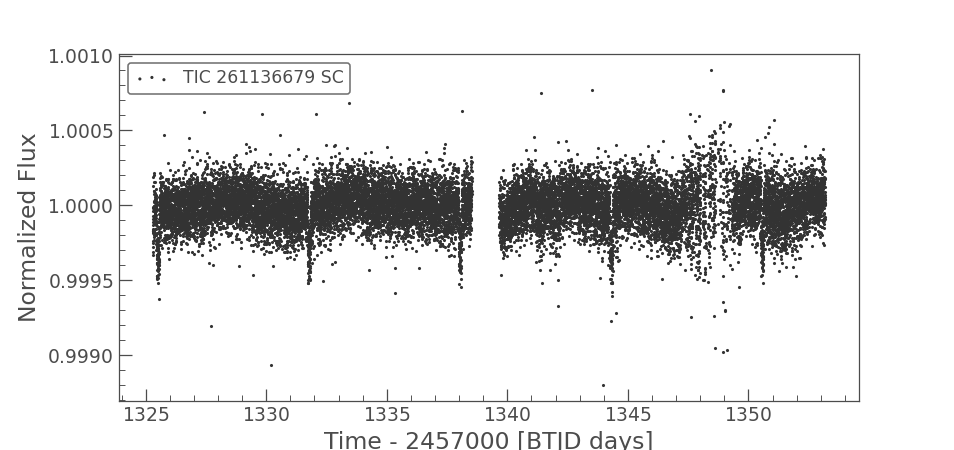

In [4]:
# sector 1 is the data used by Pyaneti documentation, which references
# [Gandolfi et al., 2018.](https://arxiv.org/abs/1809.07573)
tic, sector, cadence = 261136679, [1], "short"  # pi Men

lc_by_band, sr_all = lkep.download_lightcurves_by_cadence_type(
    tic, sector, cadence=cadence, 
    author_priority=["SPOC", "TESS-SPOC", "QLP"],
    download_dir=lk_download_dir, 
    return_sr=True)

# all lightcurves, in case the default filtering do not meet the needs
lkep.display_sr(sr_all, header=f"All available lightcurves for TIC {tic}:");

lkep.display_lc_by_band_summary(lc_by_band, header="Downloaded Lightcurves:");
for band, lc in lc_by_band.items():
    lc.scatter(label=f"{lc.label} {band}");

#### Specify the transits identified and genreate lightcurve for `Pyaneti`
<span style="background-color: yellow;">Enter your values</span>
- to supply the relevant portions of the lightcurves for `Pyaneti` modeling
- the parameters are used for other fitting purposes too
- Specify the type of model to be done, e.g., circular vs eccentric orbit, fitting stellar density vs fitting orbital distance

Template: 1planet_circular_orbit_fit_rho
Alias:    TIC261136679_c_fit_rho_toi01
Processed LC for Pyaneti input
../inpy/TIC261136679_c_fit_rho_toi01/TIC261136679_c_fit_rho_toi01_lc_s01.dat


<IPython.core.display.Javascript object>


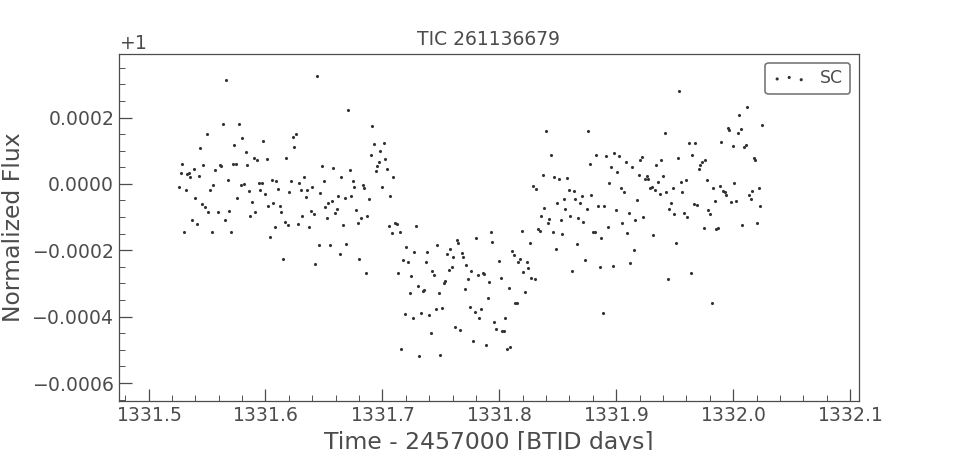

In [7]:
transit_specs = [
    dict(epoch=2365.964, duration_hr=3.01594357498873, period=6.26781105588686, 
         surround_time=0.5,  # additional time surrounding each transit to keep (as out of transits data), defaulted to 2 * duration
         # used for modeling fitting to define `Pyaneti` `min_t0` and `max_t0`
         window_epoch=lkep.Fraction(0.1), 
         # used for modeling fitting to define `Pyaneti` `min_P` and `max_P`;
         window_period=0.6,  # to sample in range [period - 0.3, period + 0.3]
         # for planet radius estimate in modeling
         transit_depth_percent=0.03,  
         label="toi01"  # a label
         )
]


# define the model skeleton to be used
model_template = lkep.ModelTemplate(
    transit_specs,  # num of planets
    "circular",  # "circular", "eccentric"
    "rho", # "orbital_distance", "rho", "single_transit"
)
# alias is used as directory name base for the modeling input / output
# - a default based on the TIC and template type is generated 
# - you can override it however you want
alias = model_template.default_alias(tic)
# alias = f"your-own-name{alias}"

# specify the directories of modeling input/output
pti_env = lkep.PyanetiEnv(pyaneti_home_dir, alias, sector)
print('Template:', model_template.abbrev)
print('Alias:   ', pti_env.alias)

# Create truncated and processed Lightcurve data to feed to Pyaneti
lc_pyaneti_dat_filepath, lc_processed, lc_processed_by_band = lkep.to_pyaneti_dat(
    lc_by_band, transit_specs, pti_env, return_processed_lc=True)
print("Processed LC for Pyaneti input")
print(lc_pyaneti_dat_filepath)
lkep.scatter_by_band(lc_processed);

#### Obtain and estimate stellar parameters
<span style="background-color: yellow;">Inspect the values to see if they are reasonable, override them if needed</span>

In [6]:
# get TIC stellar parameters from MAST and GAIA
meta = lkep.stellar_parameters_of_tic(tic, also_use_gaia=True)  
# estimates for limb darkening quadradtic coefficients
q1_q2 = lkep.get_limb_darkening_params(meta) 
# estimate Rp/R*
transits_depth = [ ts["transit_depth_percent"] / 100 for ts in transit_specs ]
r_planet_dict = lkep.estimate_planet_radius_in_r_star(meta.get("rad"), transits_depth)
# estimate a/R*
a_planet_dict = lkep.estimate_orbital_distance_in_r_star(meta, transit_specs)


lkep.display_stellar_meta_links(meta, header="Parameter sources:")
(
    meta["ID"], q1_q2, r_planet_dict, a_planet_dict, 
    'mass*', meta['mass'], meta['e_mass'], 'radius*', meta['rad'], meta['e_rad'], 
    'Teff*', meta['Teff'], meta['e_Teff'],
    'logg', meta['logg'],  # used to derive q1_q2, along with Teff*
    "rho*:", meta['rho'], meta['e_rho'],
)

('261136679',
 {'q1': 0.31663128999999995,
  'e_q1': 0.11,
  'q2': 0.2972276523902613,
  'e_q2': 0.1,
  'u1': 0.3345,
  'e_u1': 0.12,
  'u2': 0.2282,
  'e_u2': 0.08},
 {'r_planet_in_r_star': array([0.0173]),
  'min_r_planet_in_r_star': array([0.]),
  'max_r_planet_in_r_star': array([0.0346])},
 {'min_a': array([2.]), 'max_a': array([99.])},
 'mass*',
 1.1,
 0.140389,
 'radius*',
 1.1744143,
 0.06271982,
 'Teff*',
 5960.5,
 165.8335,
 'logg',
 4.3589,
 'rho*:',
 1.0226105813781257,
 0.1994810255798663)

##### Override the stellar parameters if needed
- e.g., ExoFOP may have more updated information.

In [ ]:
# Override the parameters if needed

# meta["Teff"] = 5738.0
# q1_q2["q1"] = 0.0
# q1_q2["e_q1"] = 0.9
# q1_q2["q2"] = 0.0
# q1_q2["e_q2"] = 0.9

# a_planet_dict=dict(min_a=30., max_a=40.)  # set after observing initial model result 

# redoing estimates (if needed) in case the changes in meta affect the results
#
# estimates for limb darkening quadradtic coefficients
# q1_q2 = lkep.get_limb_darkening_params(meta) 
# estimate Rp/R*
# r_planet_dict = lkep.estimate_planet_radius_in_r_star(meta.get("rad"), transit_specs[0]["transit_depth_percent"] / 100)
# estimate a/R*
# a_planet_dict = lkep.estimate_orbital_distance_in_r_star(meta)

(
    meta["ID"], q1_q2, r_planet_dict, a_planet_dict, 
    'mass*', meta['mass'], meta['e_mass'], 'radius*', meta['rad'], meta['e_rad'], 
    'Teff*', meta['Teff'], meta['e_Teff'],
    'logg', meta['logg'],  # used to derive q1_q2, along with Teff*
    "rho*:", meta['rho'], meta['e_rho'],
)

#### Misc. model parameters
You can usually just run the cell and use the default

In [8]:
mcmc_controls = lkep.define_mcmc_controls()
impact_parameter = lkep.define_impact_parameter()

mcmc_controls, impact_parameter

({'mcmc_thin_factor': 1, 'mcmc_niter': 500, 'mcmc_nchains': 100},
 {'min_b': 0.0, 'max_b': 1.0})

#### Generate `input_fit.py`

In [9]:
import logging
lkep.log_to_stdout_at_level(logging.INFO)  # set to INFO to show priors resolution

input_fit_filepath = lkep.create_input_fit(
    model_template, tic, alias, pti_env, 
    lc_processed_by_band, transit_specs, impact_parameter, meta, q1_q2, r_planet_dict, a_planet_dict,
    mcmc_controls, 
    write_to_file=True, return_content=False)

print("Model Template type:", model_template.abbrev)
lkep.display_pyaneti_input_py_location(input_fit_filepath)
lkep.display_pyaneti_instructions(pti_env)

Prior epoch: resolved to Uniform (by mean and window)
Prior period: resolved to Uniform (by mean and window)
Prior b: resolved to Uniform
Prior a: resolved to Gaussian
Prior rp: resolved to Uniform
Prior q1: resolved to Gaussian
Prior q2: resolved to Gaussian
Model Template type: 1planet_circular_orbit_fit_rho



To do the modeling, just run next cell. Or run the following in a separate terminal:
```
!cd /home/orionlee/dev/pyaneti; python pyaneti.py  TIC261136679_c_fit_rho_toi01
```
    

#### Run `Pyaneti`

In [13]:
!echo Running Pyaneti for $alias : 
!cd $pyaneti_home_dir ;  python pyaneti.py $alias
lkep.beep();  # let you know it is done

Running Pyaneti for TIC261136679_c_fit_rho_toi01 :



------------------------------

    INITIAL CONFIGURATION     

------------------------------

Star           = TIC261136679_c_fit_rho_toi01

No. planets    = 1

------------------------------

iter max       = 100000000

thin factor    = 1

nconv          = 500

nwalkers       = 100

------------------------------

fit RV         = [False]

fit Transit    = [True]

------------------------------

------------------------------

  PLANET TIC261136679_c_fit_rho_toi01b 

------------------------------

        PRIOR RANGES          

------------------------------

T0 = u[ 2365.9577 , 2365.9703 ]

P  = u[ 5.9678 , 6.5678 ]

ew1= f[ 0.0000 , 0.0000 ]

ew2= f[ 0.0000 , 0.0000 ]

b  = u[ 0.0000 , 1.0000 ]

a  = g[ 1.0226 , 0.1995 ]

rp = u[ 0.0000 , 0.0346 ]

K  = f[ 0.0000 , 1.0000 ]

------------------------------

 Other parameter priors 

------------------------------

q1  = g[ 0.3166 , 0.1100 ]

q2  = g[ 0.2972 , 0.1000 ]

telesco

AttributeError: module 'lightkurve_ext_pyaneti' has no attribute 'beep'

### Model result

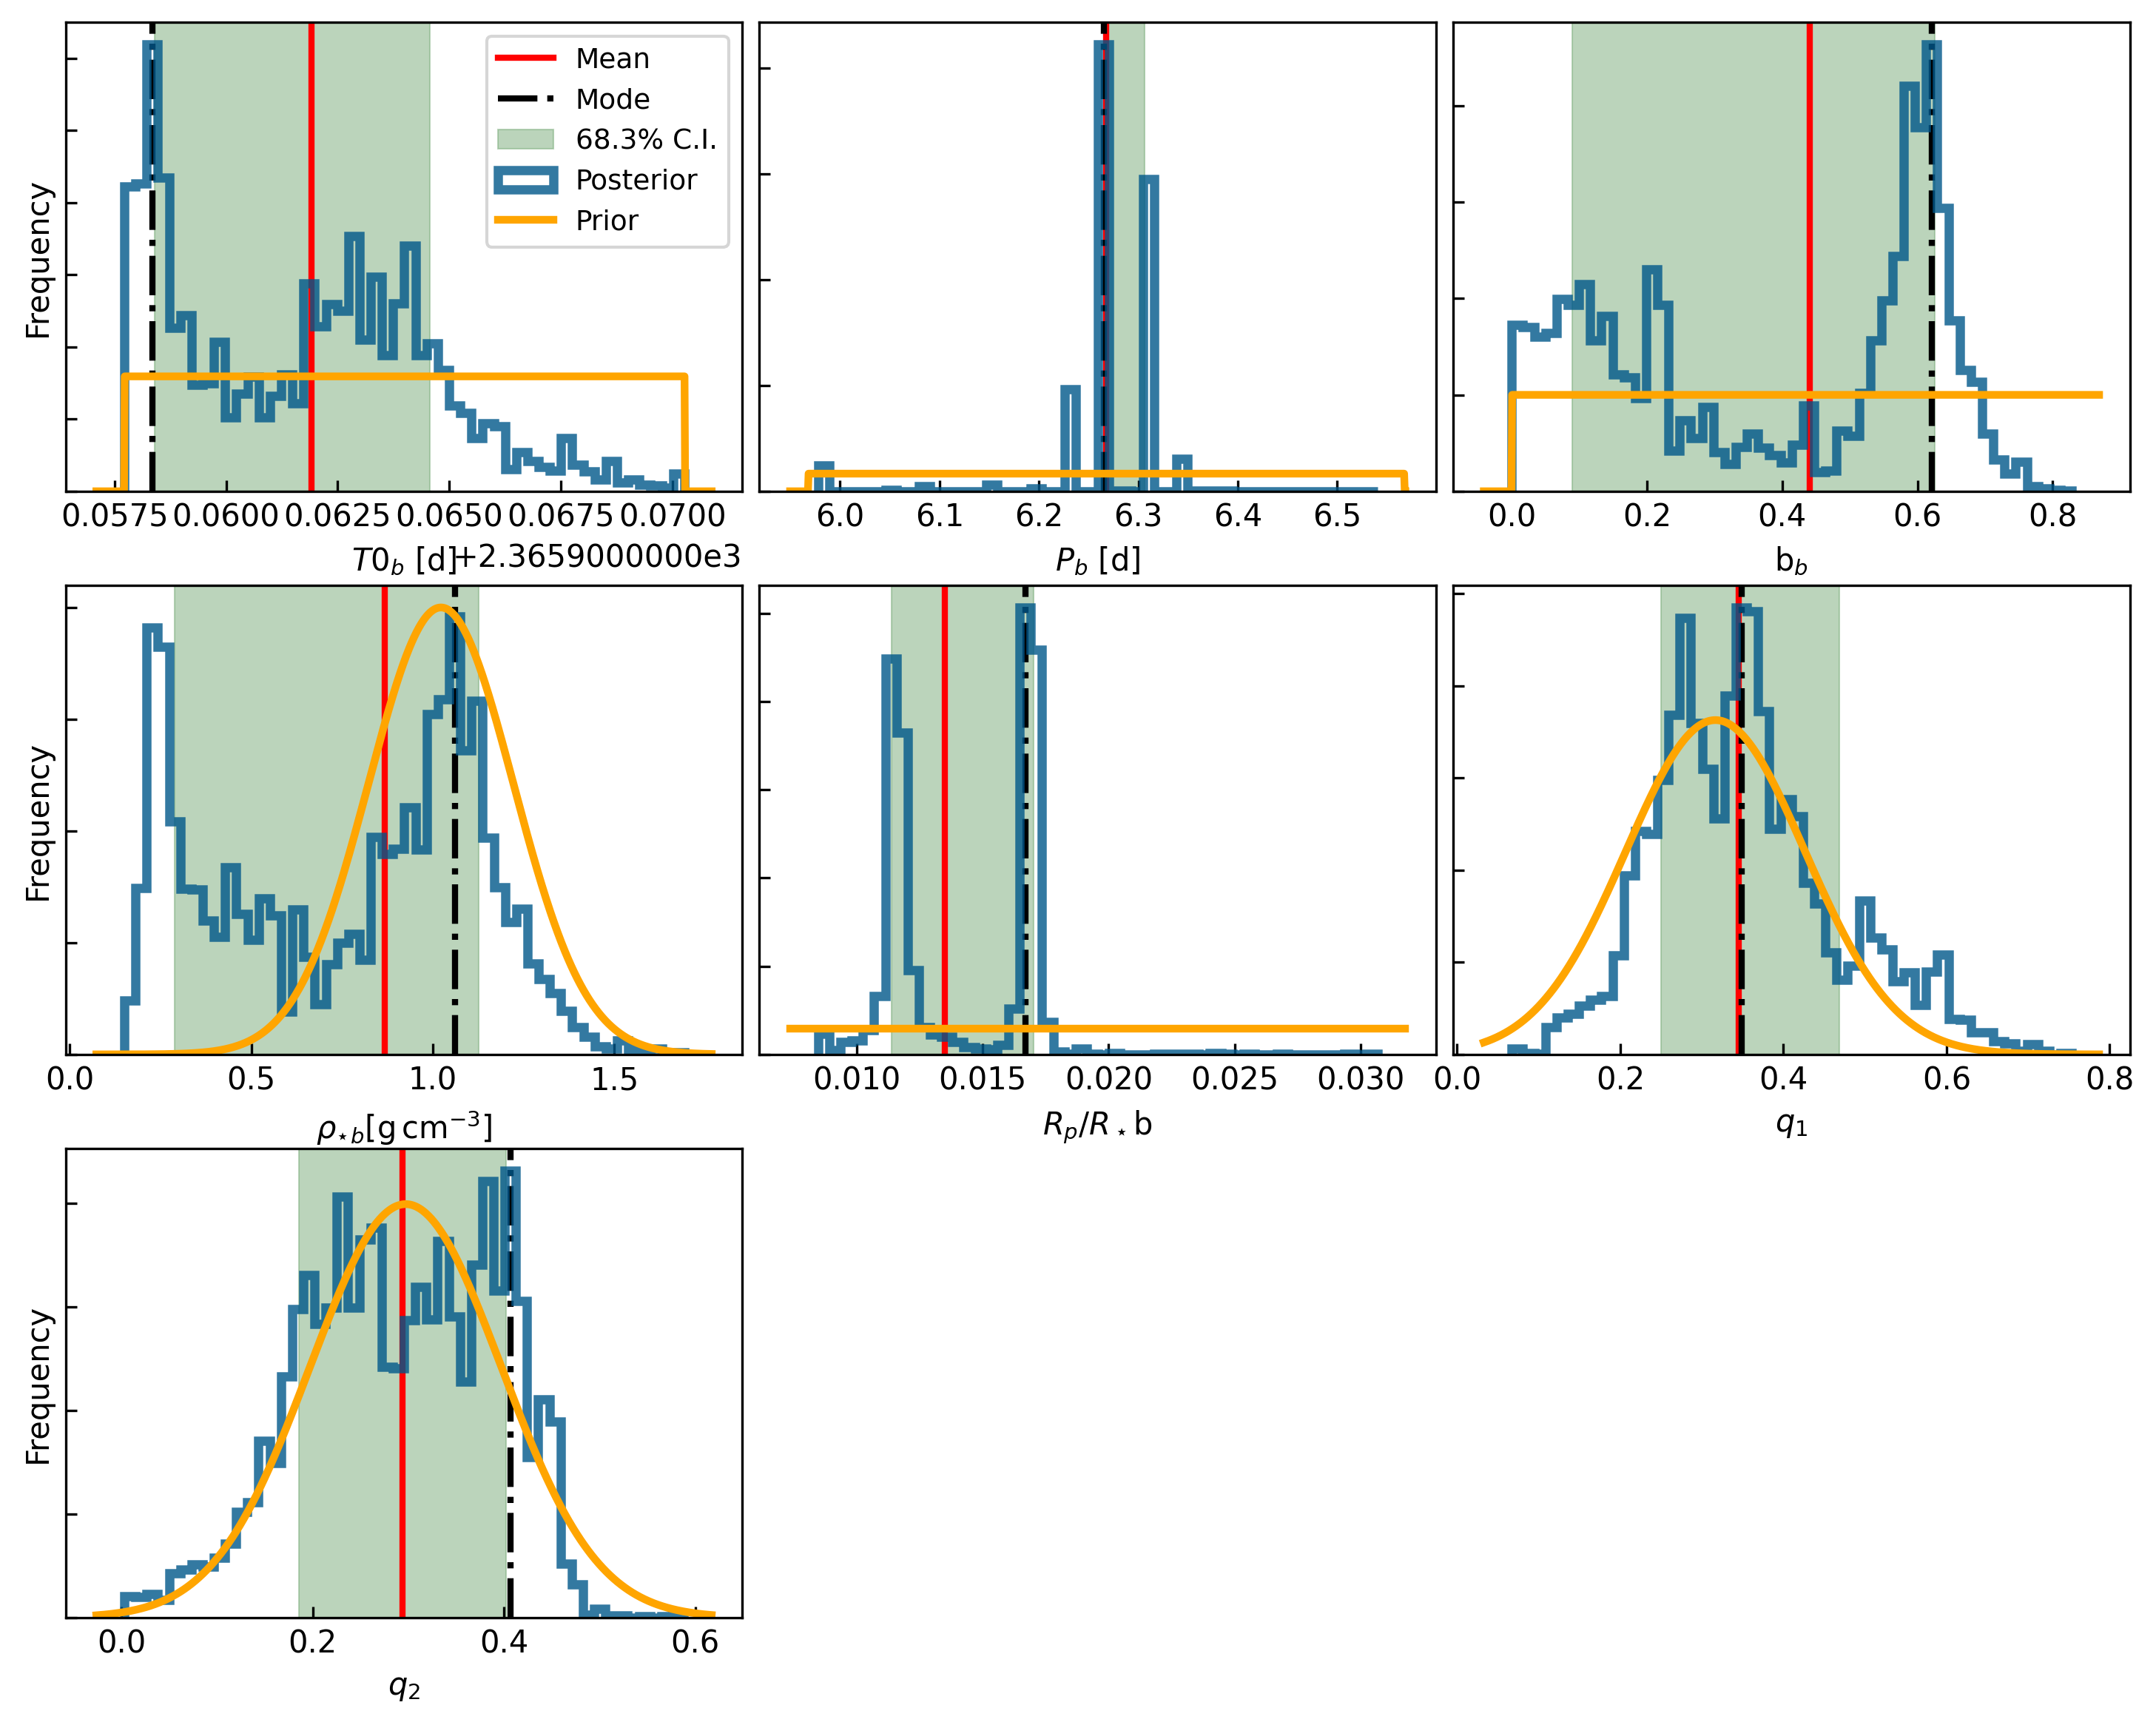

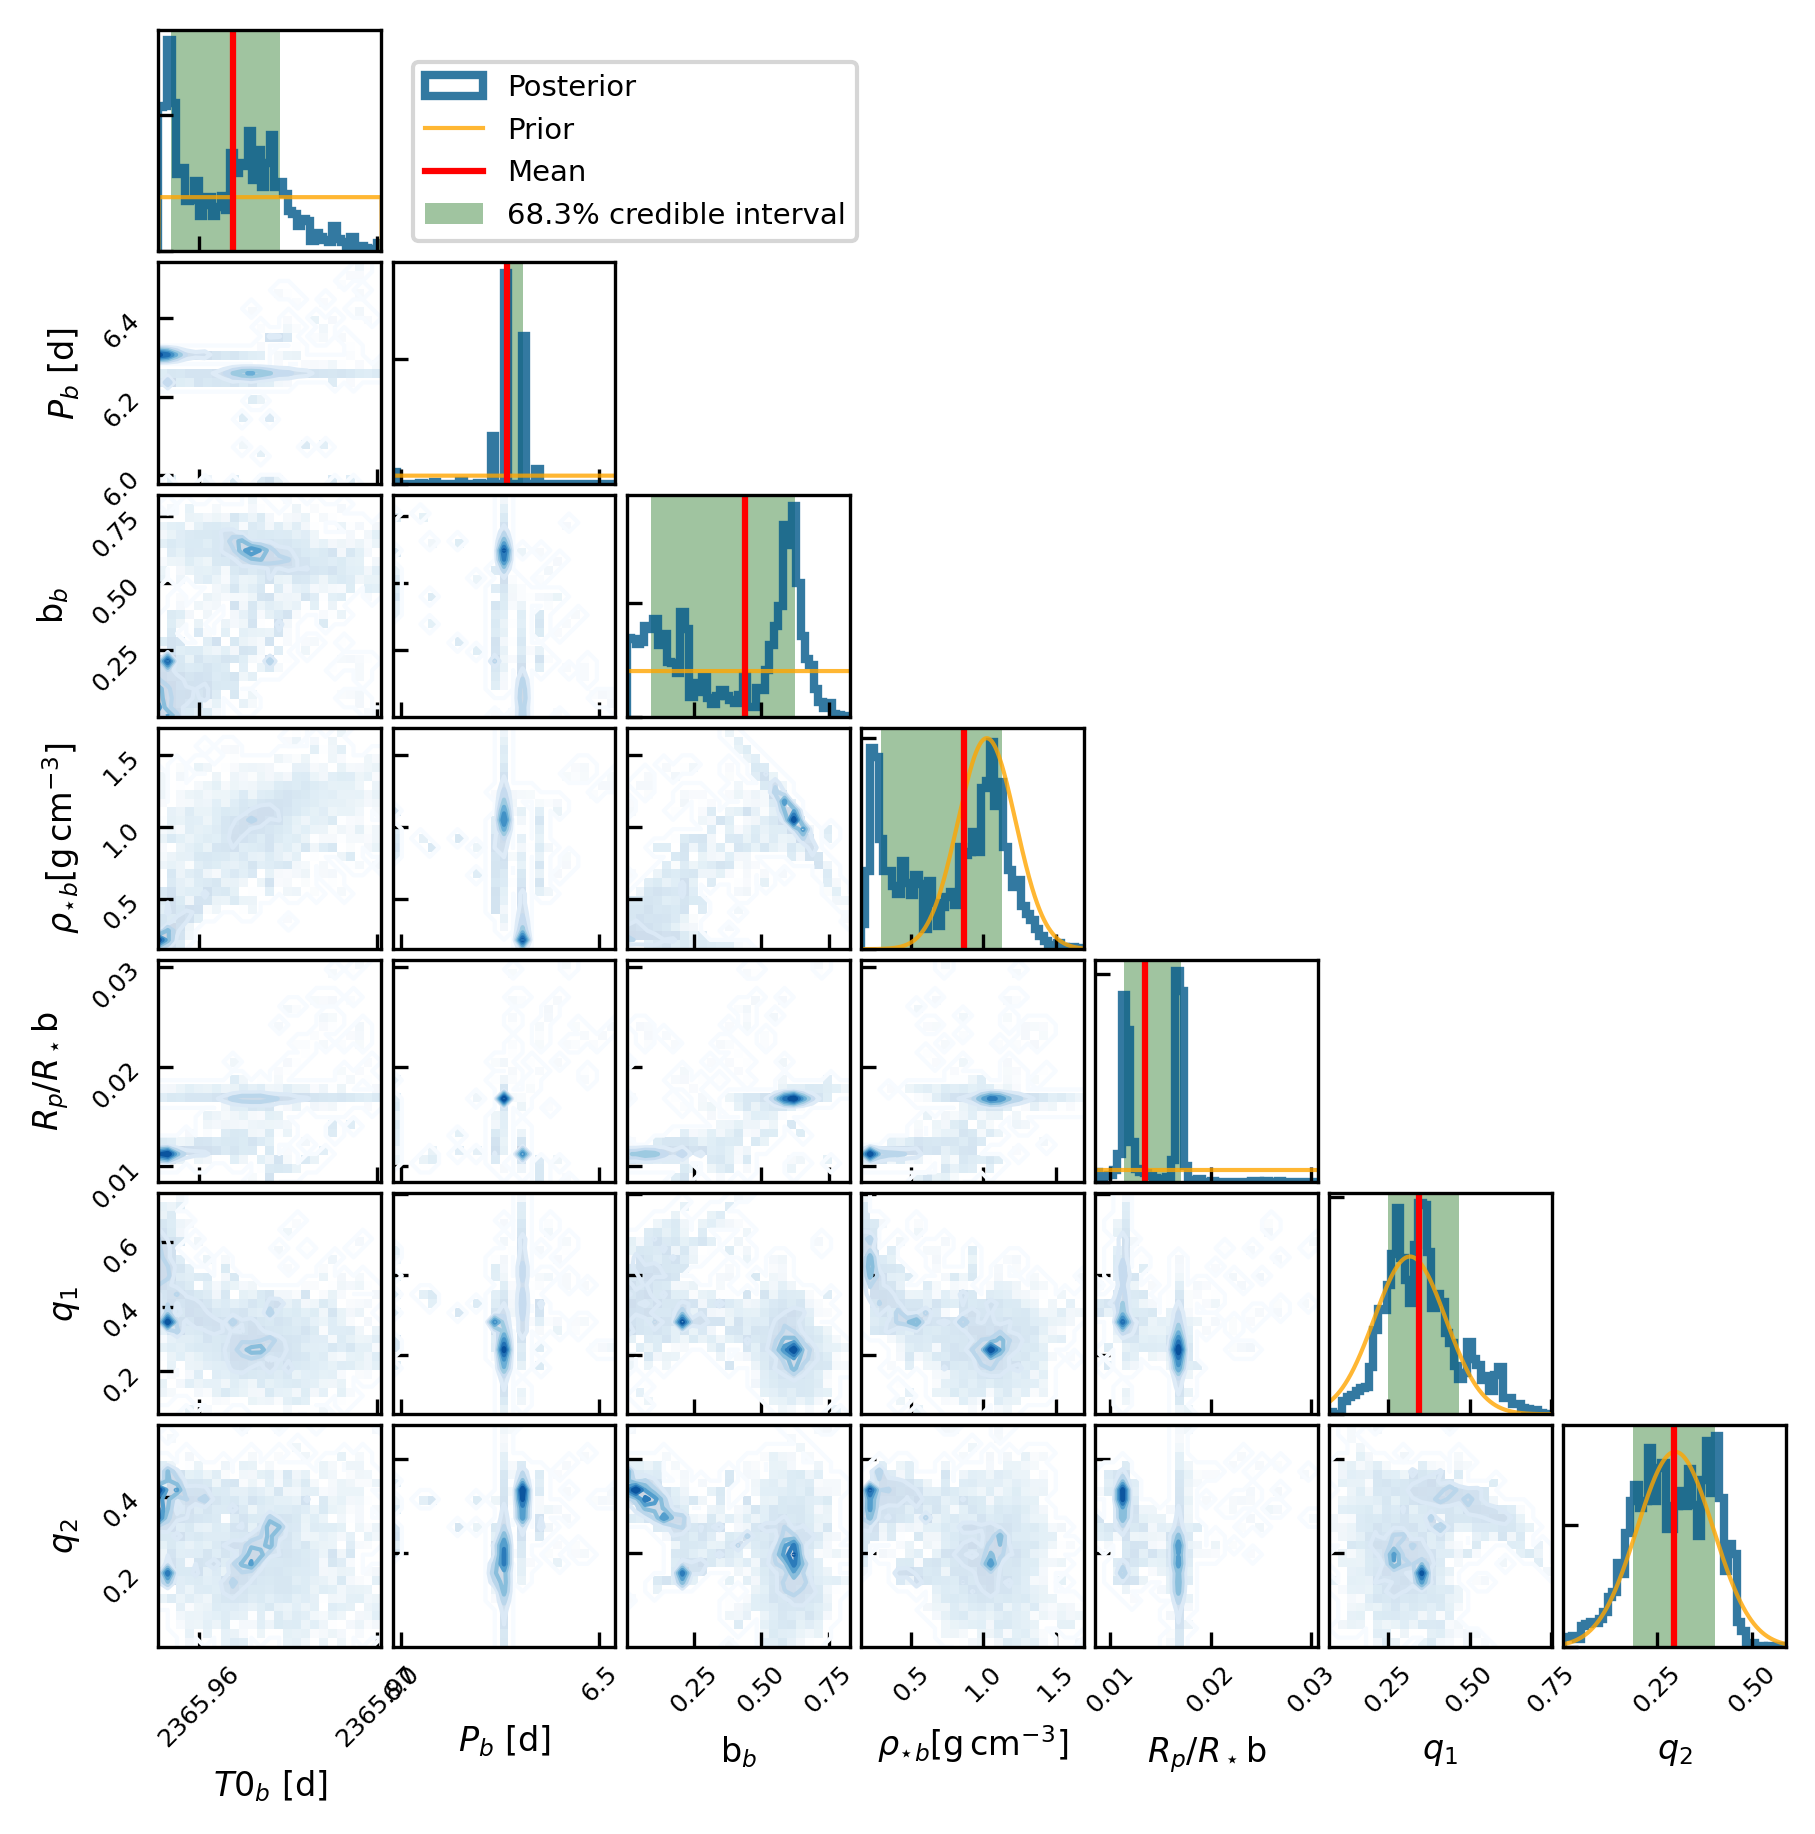

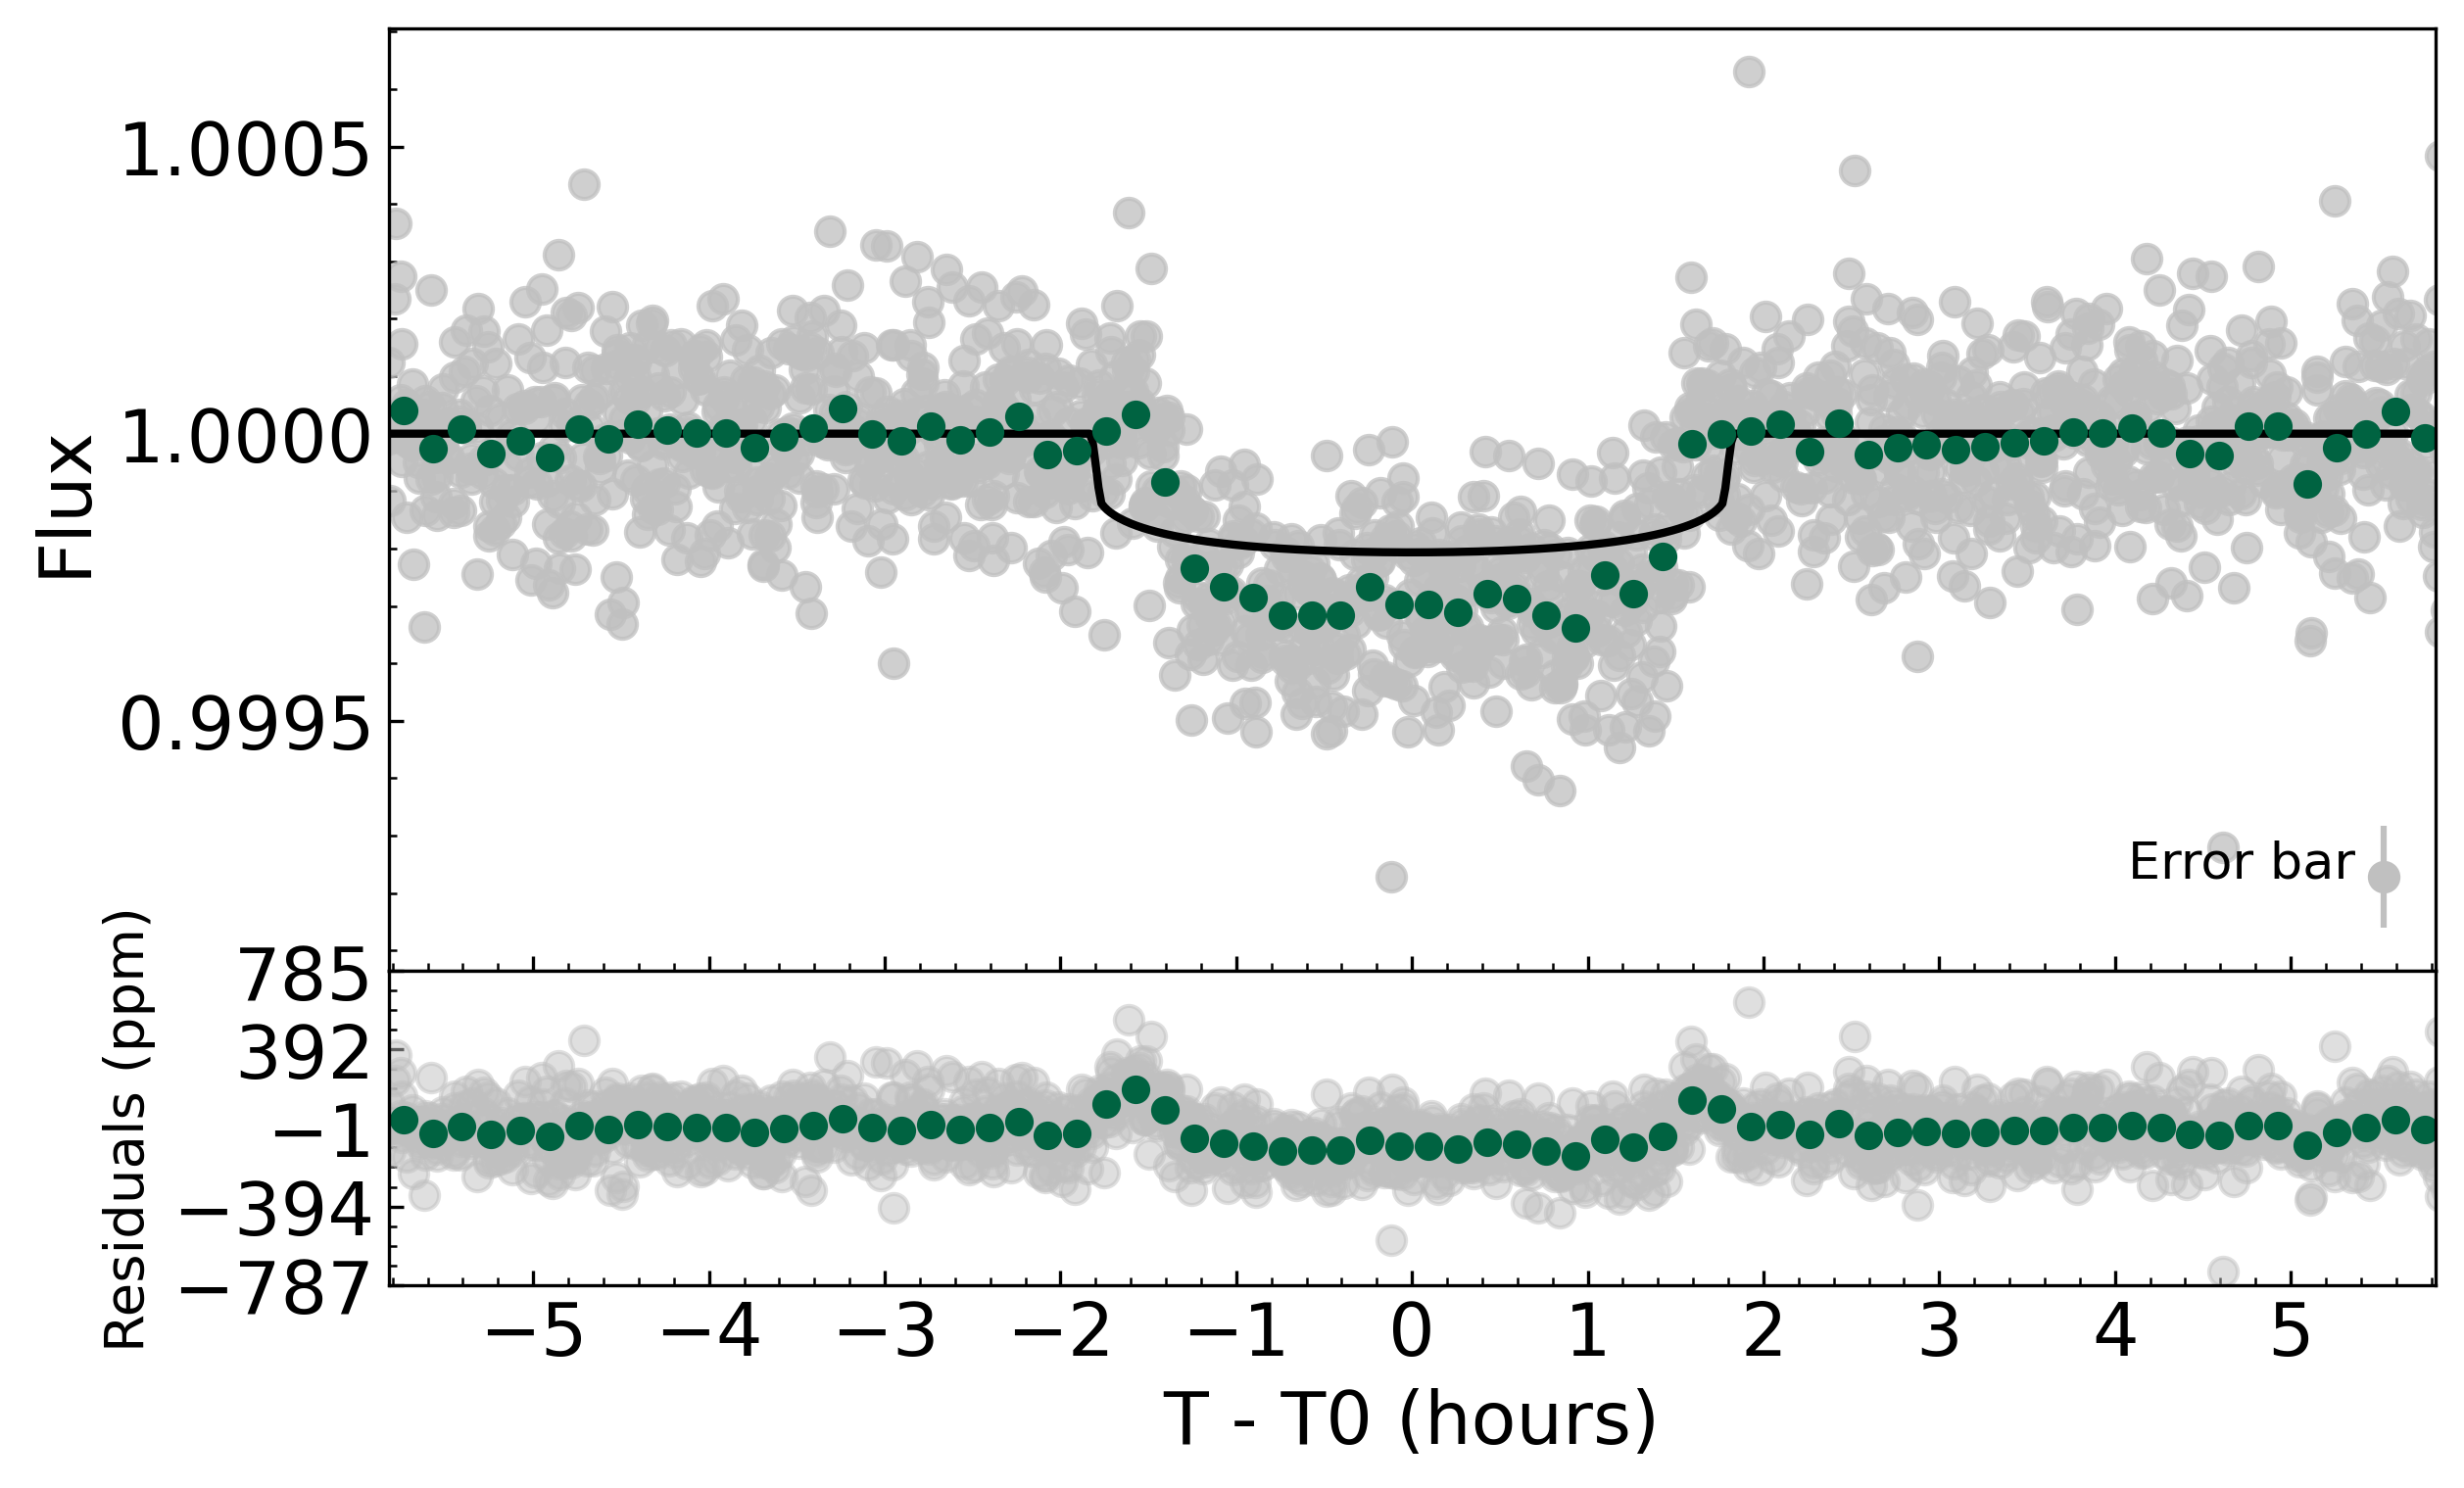

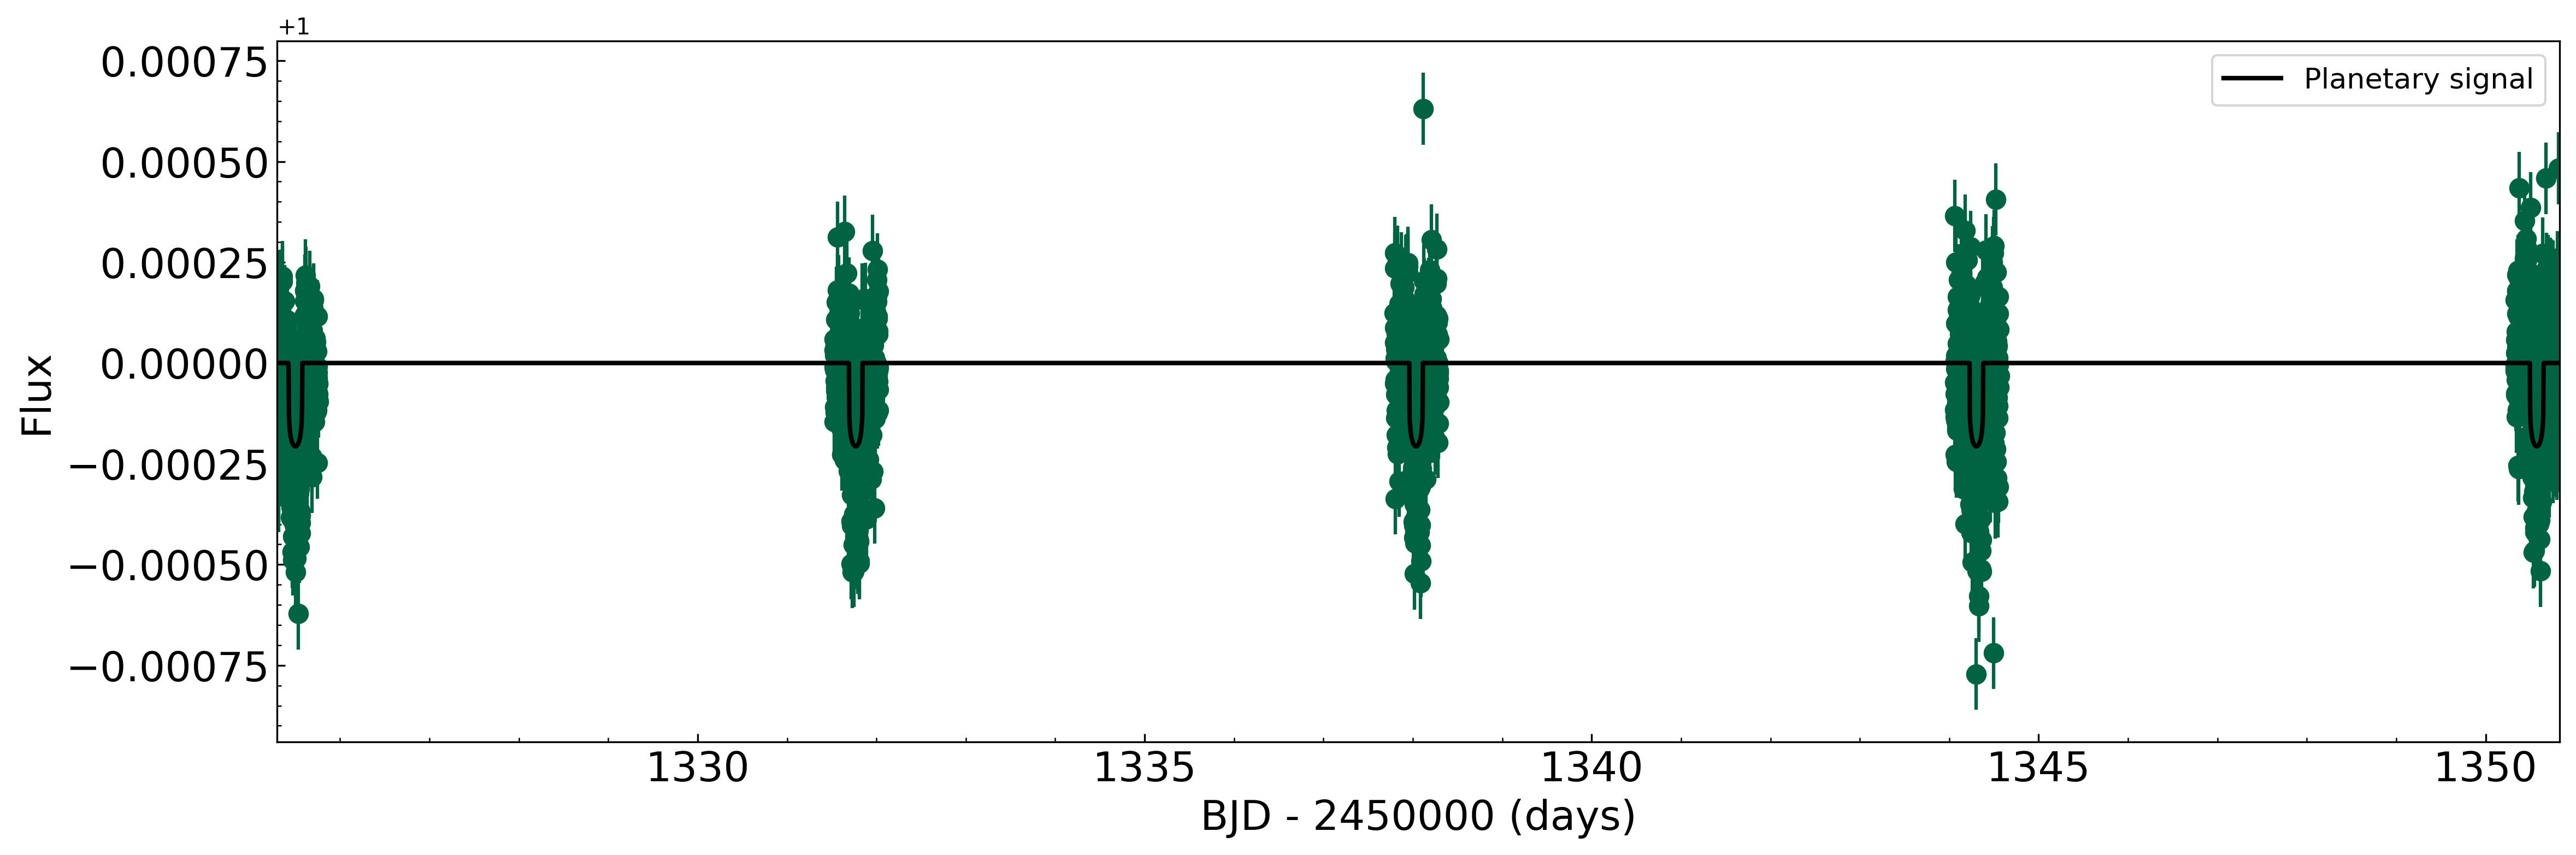

In [11]:
lkep.save_params_as_txt_file(pti_env)  # for ease of sharing on Google Drive
lkep.copy_input_fit_py_to_out_dir(pti_env)  # for ease of sharing on Google Drive
lkep.display_model(pti_env, model_template,
    show_params=True, show_posterior=True, show_correlations=True, show_transits=True, show_lightcurve=True, show_chains=False)

#### Miscellaneous

<IPython.core.display.Javascript object>


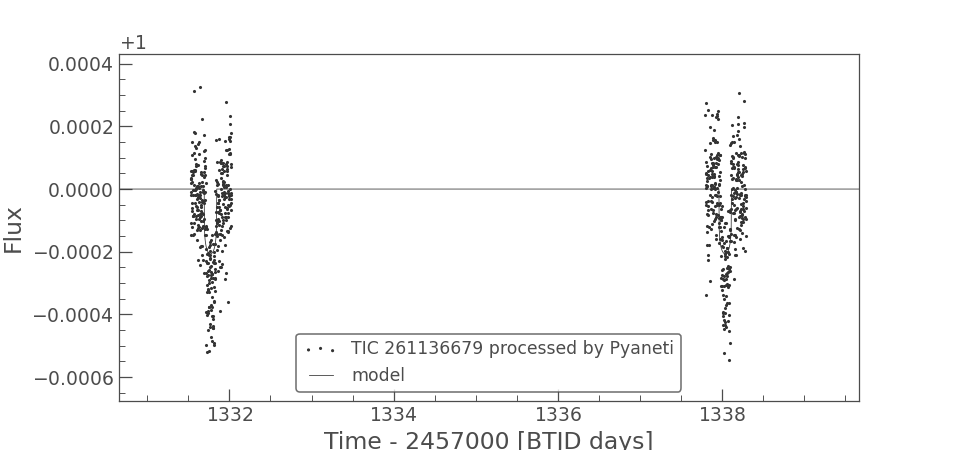

In [12]:
# read processed LC data from Pyaneti output (rather than the figures above)

from pathlib import Path

filename = Path(pti_env.target_out_dir, f"{pti_env.alias}-trdata_lightcurve.txt")
lc_tr = lkep.read_pyaneti_lc_dat(filename, time_format="btjd")

filename = Path(pti_env.target_out_dir, f"{pti_env.alias}-trmodel_lightcurve.txt")
lc_model = lkep.read_pyaneti_lc_dat(filename, time_format="btjd")

ax = lc_tr.scatter(label=f"TIC {tic} processed by Pyaneti");
ax = lc_model.plot(ax=ax, label="model");


In [ ]:
# original processed / truncated LC data that feeds to Pyaneti

filename = pti_env.lc_dat_filepath
lc_read = lkep.read_pyaneti_lc_dat(filename, time_format="btjd")

lc_trunc = lc_read.truncate(None, 1328)
lc_trunc.scatter(label="{tic} that feeds to Pyaneti");

print("window length: ", lc_trunc.time[-1] - lc_trunc.time[0])
print("cadence (min): ", 24 * 60 * np.nanmedian(np.diff(lc_trunc.time)))